In [ ]:

!pip install sklearn

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F13720%2F18513%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240430%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240430T044129Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3b13736575e56d35ea57900a4c38809d7cbaa85e7d36d9311ebc02659374bbc2ffa54f2167ea08db361c95a00d54d66a9c8dd1c76322fc7d9fa63098eb9f161197bfdb675f1de8994962bd267e823dd9a1dde686196fbb5b2ddd40ec86cab8f2c740b4cf6c08e08ebfbbb7175271d9b13aa288ba2e7f507a0cf3edaa8d1bf044dd5cfc981821d4f8bfebb90ddcf03752a9cfce9544cbf069adfe238ab591399da07b2bde5266100767b2c13bee40392a58a9003025c7fb77be59a05235ce23b15b160295628a1c358be6cd85813d9932452ebb1d2dc1d8140a2dac23dd571e03149489f8102aea29f29814127ee92384c394cc5462982a7a9aa610908b968f4f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
[==================================================] 16425 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


<font size=5 > <p style="color:purple"> Which Factors Influence the Price of Health Insurance?

<img src="https://i.imgur.com/zTnvOcb.jpg" width="800">

<font size='2'>Many factors that affect how much you pay for health insurance are not within your control. Nonetheless, it's good to have an understanding of what they are. Here are some factors that affect how much health insurance premiums cost

* **age:** age of primary beneficiary

* **sex:** insurance contractor gender, female, male

* **bmi:** Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* **children:** Number of children covered by health insurance / Number of dependents

* **smoker:** Smoking

* **region:** the beneficiary's residential area in the US, northeast, southeast, southwest, northwest

<font size=5><p style="color:purple"> EDA and Visualizations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('../input/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
df.shape

(1338, 7)

In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [ ]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<font size='2' font>We have 0 missing values which is very good.
Now let's do EDA with some cool graphs :) First we'll see how the charges are distributed according to given factors

Text(0.5, 1.0, 'Distribution of Charges')

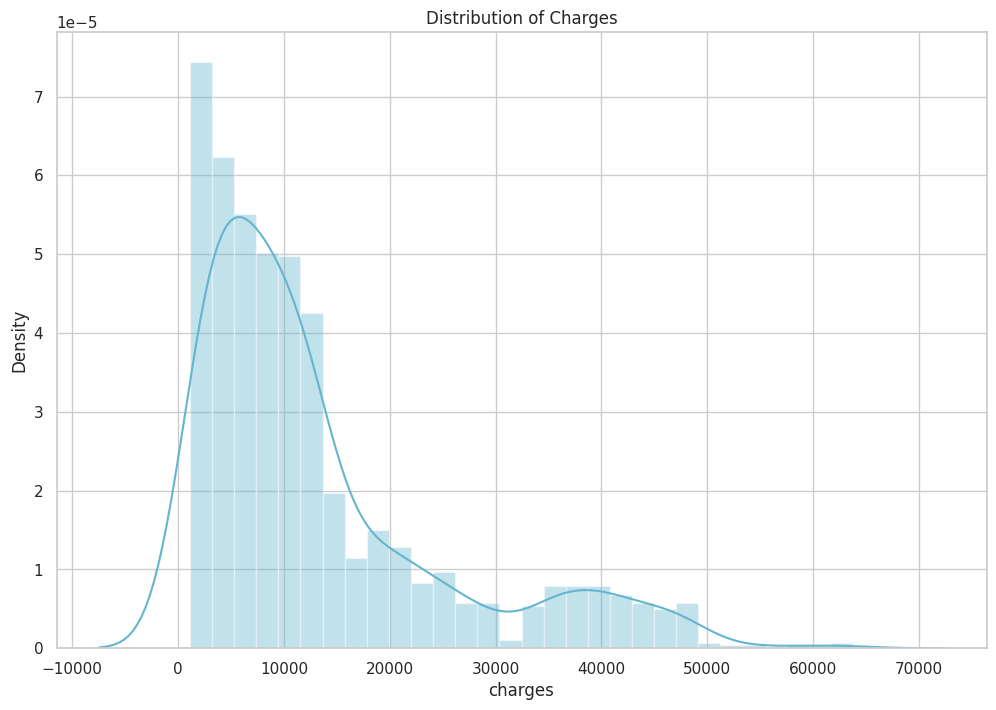

In [ ]:
sns.set(style='whitegrid')
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.distplot(df['charges'], kde = True, color = 'c')
plt.title('Distribution of Charges')

<font size='2' font>This distribution is right-skewed. To make it closer to normal we can apply natural log

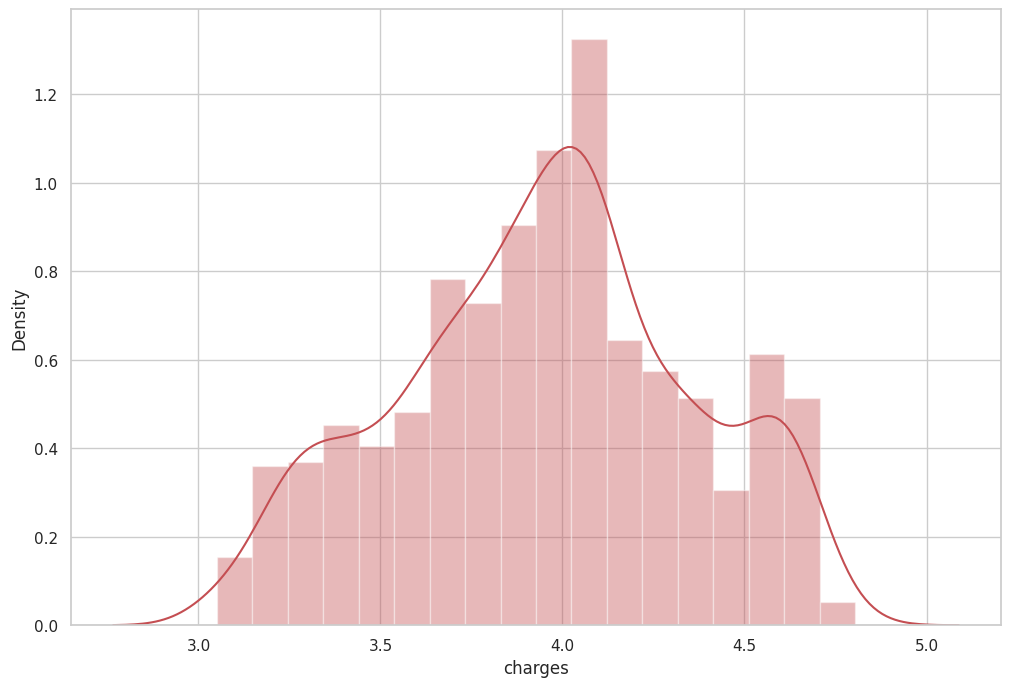

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.distplot(np.log10(df['charges']), kde = True, color = 'r' )

<font size=2> Now let's look at the charges by region

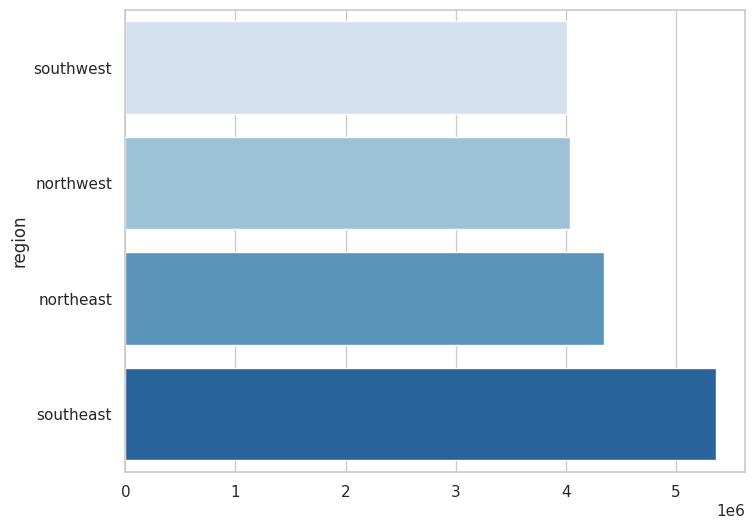

In [ ]:
charges = df['charges'].groupby(df.region).sum().sort_values(ascending = True)
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.barplot(x = charges.head().values, y = charges.head().index, palette='Blues')

<font size='2' font>So overall the highest medical charges are in the Southeast and the lowest are in the Southwest. Taking into account certain factors (sex, smoking, having children) let's see how it changes by region

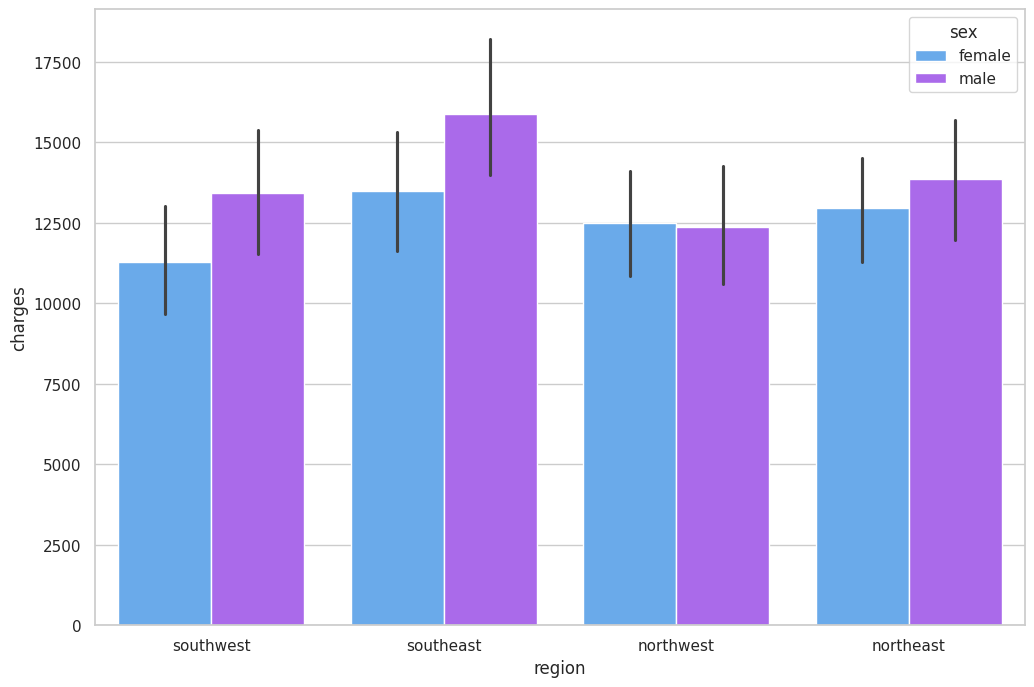

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='sex', data=df, palette='cool')

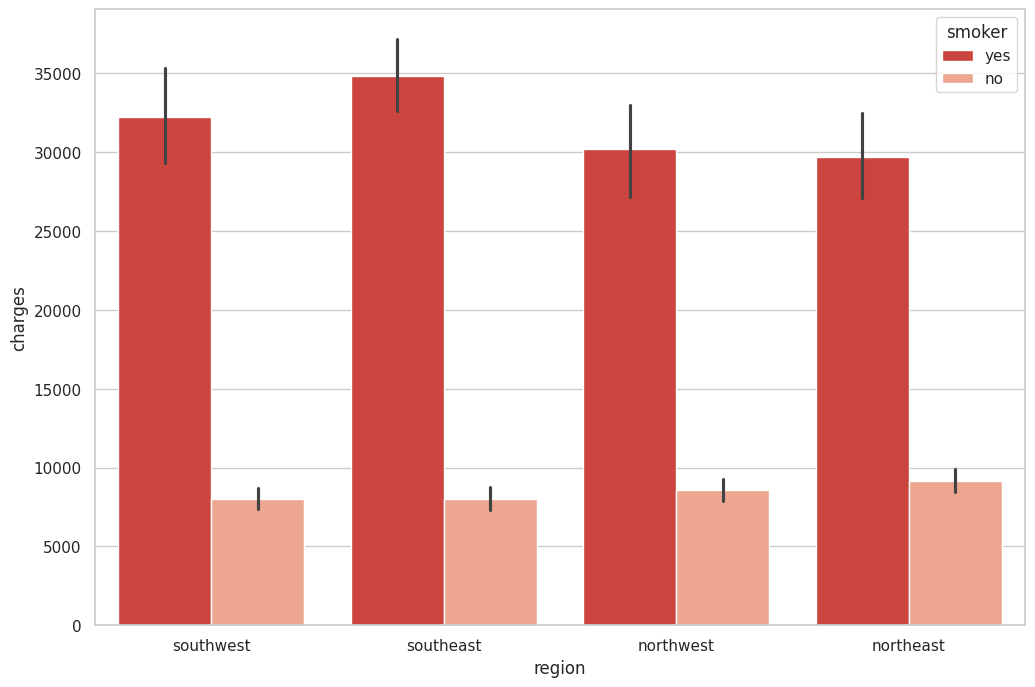

In [ ]:
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.barplot(x = 'region', y = 'charges',
                 hue='smoker', data=df, palette='Reds_r')

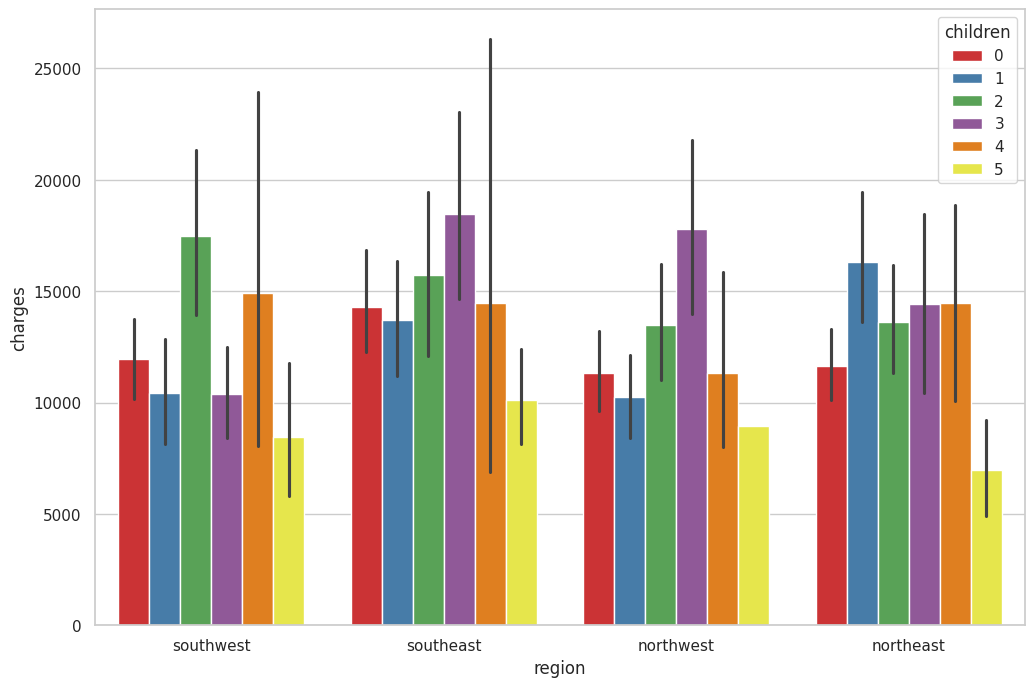

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='children', data=df, palette='Set1')

<font size='2' font>As we can see from these barplots the highest charges due to smoking are still in the Southeast but the lowest are in the Northeast. People in the Southwest generally smoke more than people in the Northeast, but people in the Northeast have higher charges by gender than in the Southwest and Northwest overall. And people with children tend to have higher medical costs overall as well

<font size='2' font>Now let's analyze the medical charges by age, bmi and children according to the smoking factor

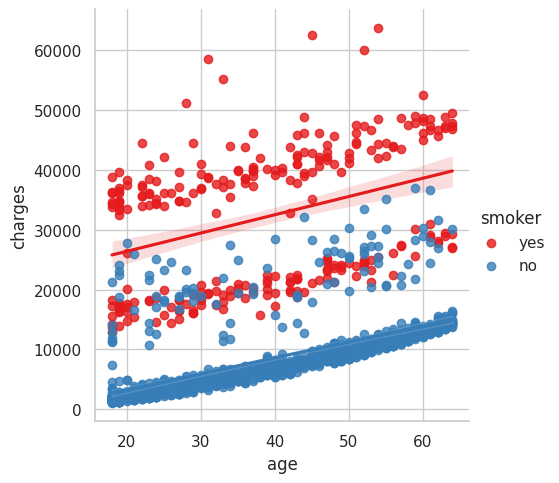

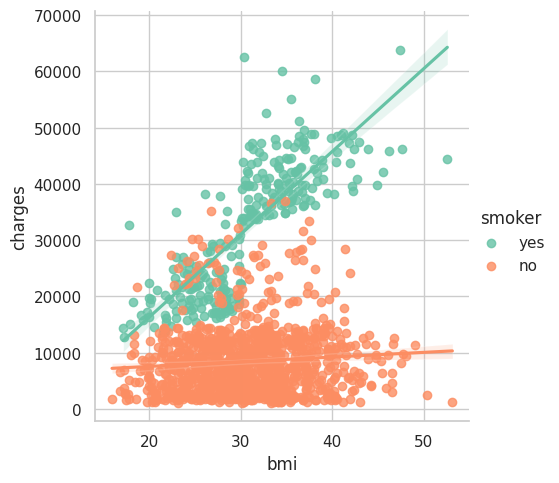

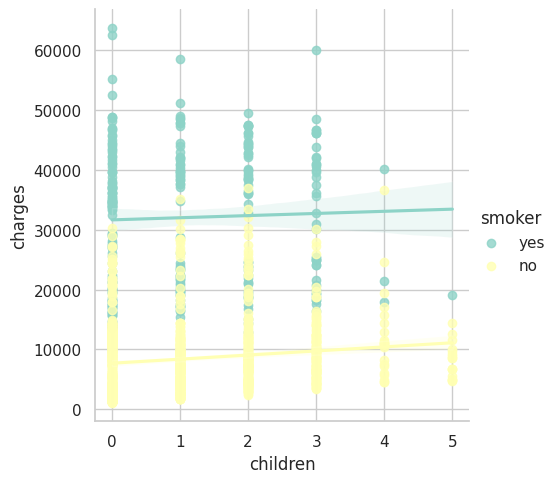

In [ ]:
ax = sns.lmplot(x = 'age', y = 'charges', data=df, hue='smoker', palette='Set1')
ax = sns.lmplot(x = 'bmi', y = 'charges', data=df, hue='smoker', palette='Set2')
ax = sns.lmplot(x = 'children', y = 'charges', data=df, hue='smoker', palette='Set3')

<font size='2' font>Smoking has the highest impact on medical costs, even though the costs are growing with age, bmi and children. Also people who have children generally smoke less, which the following violinplots shows too

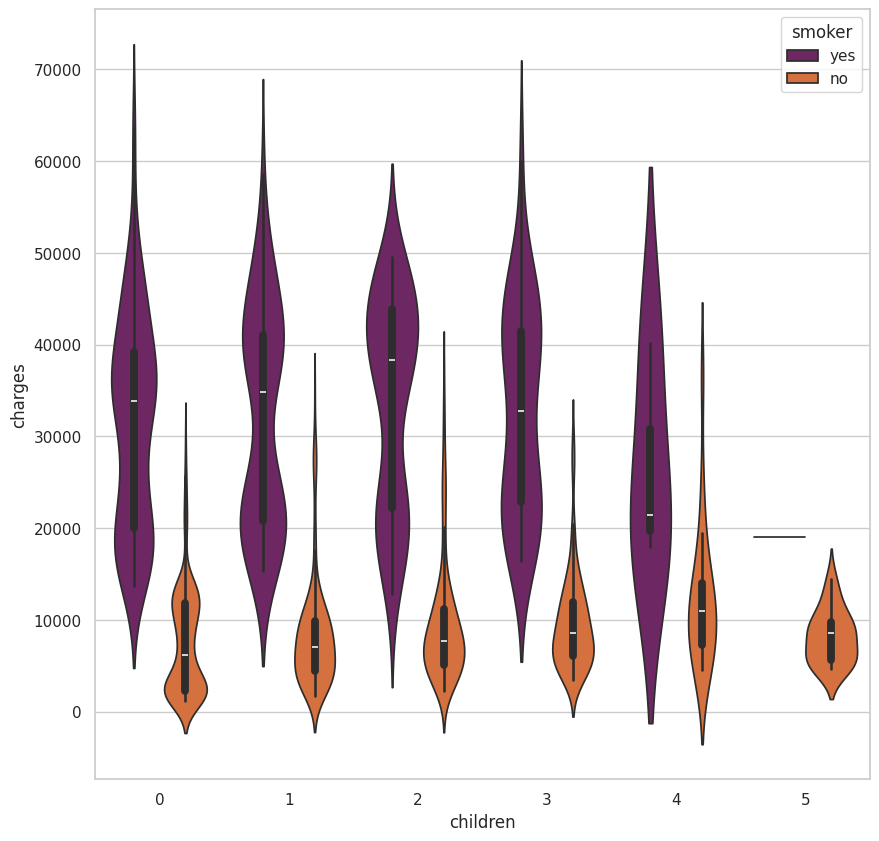

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.violinplot(x = 'children', y = 'charges', data=df,
                 orient='v', hue='smoker', palette='inferno')

In [ ]:
##Converting objects labels into categorical
df[['sex', 'smoker', 'region']] = df[['sex', 'smoker', 'region']].astype('category')
df.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

In [ ]:
##Converting category labels into numerical using LabelEncoder
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
label.fit(df.sex.drop_duplicates())
df.sex = label.transform(df.sex)
label.fit(df.smoker.drop_duplicates())
df.smoker = label.transform(df.smoker)
label.fit(df.region.drop_duplicates())
df.region = label.transform(df.region)
df.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

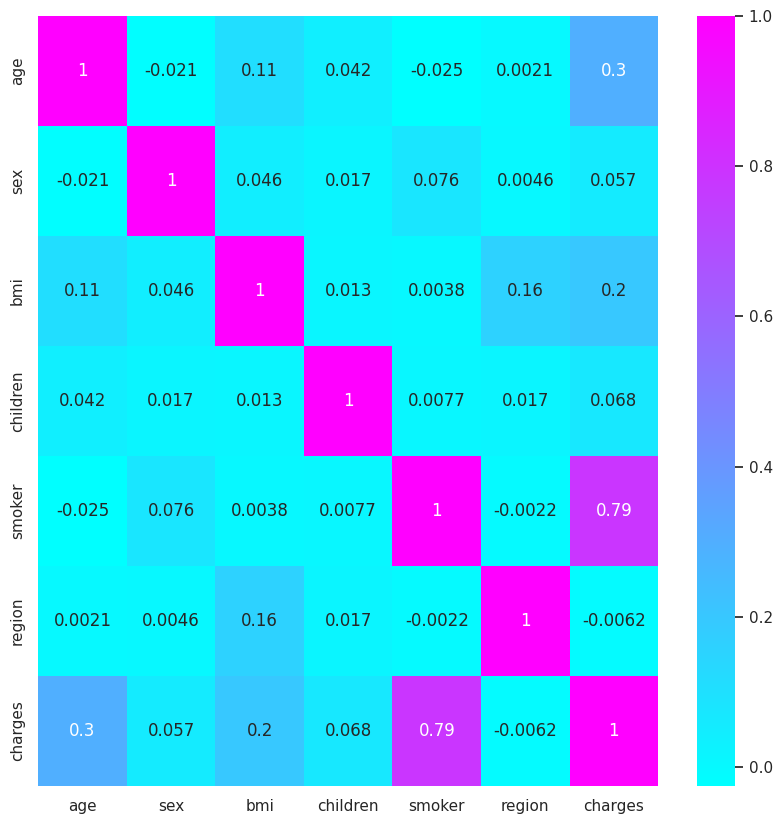

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(df.corr(), annot=True, cmap='cool')

<font size='2' font>No correlation, except with the smoking

<font size=5><p style="color:purple"> Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split as holdout
from sklearn.linear_model import LinearRegression
from sklearn import metrics
x = df.drop(['charges'], axis = 1)
y = df['charges']
x_train, x_test, y_train, y_test = holdout(x, y, test_size=0.2, random_state=0)
Lin_reg = LinearRegression()
Lin_reg.fit(x_train, y_train)
print(Lin_reg.intercept_)
print(Lin_reg.coef_)
print(Lin_reg.score(x_test, y_test))

-11661.98390882441
[  253.99185244   -24.32455098   328.40261701   443.72929547
 23568.87948381  -288.50857254]
0.7998747145449959


<font size='2' font>The result we got is good enough, but we can try to improve it a bit by reducing unimportant features later

<font size=5><p style="color:purple">Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
Ridge = Ridge(alpha=0.5)
Ridge.fit(x_train, y_train)
print(Ridge.intercept_)
print(Ridge.coef_)
print(Ridge.score(x_test, y_test))

-11643.440927495825
[ 2.53893751e+02 -2.15112284e+01  3.28339566e+02  4.44238477e+02
  2.35009674e+04 -2.89027871e+02]
0.7996989632063141


<font size=5><p style="color:purple"> Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

Lasso = Lasso(alpha=0.2, fit_intercept=True, precompute=False, max_iter=1000,
              tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

Lasso.fit(x_train, y_train)

print(Lasso.intercept_)
print(Lasso.coef_)
print(Lasso.score(x_test, y_test))

-11661.83892903954
[ 2.53991436e+02 -2.34569821e+01  3.28389438e+02  4.43587436e+02
  2.35676136e+04 -2.88340296e+02]
0.7998690236224706


<font size=5><p style="color:purple"> Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor as rfr
x = df.drop(['charges'], axis=1)
y = df.charges
Rfr = rfr(n_estimators = 100, criterion = 'squared_error',
                              random_state = 1,
                              n_jobs = -1)
Rfr.fit(x_train,y_train)
x_train_pred = Rfr.predict(x_train)
x_test_pred = Rfr.predict(x_test)


print('MSE train data: %.3f, MSE test data: %.3f' %
      (mse(x_train_pred, y_train),
       mse(x_test_pred, y_test)))
print('R2 train data: %.3f, R2 test data: %.3f' %
      (r2(y_train,x_train_pred),
       r2(y_test,x_test_pred)))

MSE train data: 3628893.887, MSE test data: 19730453.910
R2 train data: 0.975, R2 test data: 0.876


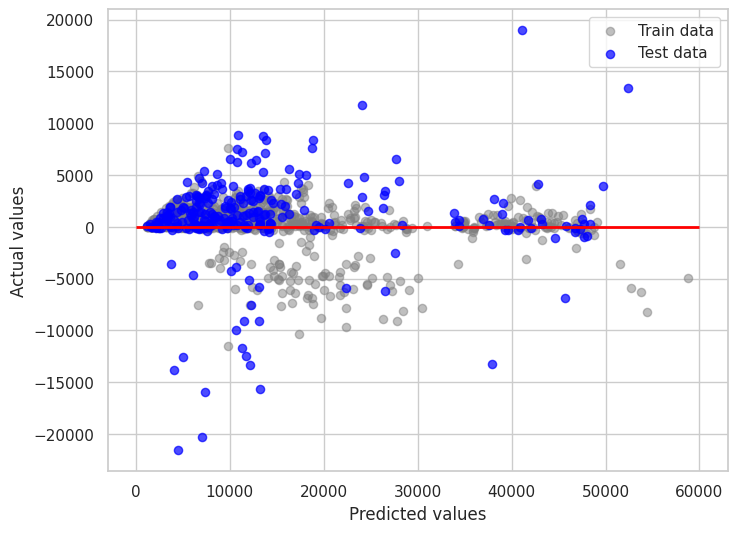

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(x_train_pred, x_train_pred - y_train,
          c = 'gray', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
plt.scatter(x_test_pred, x_test_pred - y_test,
          c = 'blue', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.legend(loc = 'upper right')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')

Feature importance ranking


1.smoker(0.601678)
2.bmi(0.218831)
3.age(0.136943)
4.children(0.020990)
5.region(0.015165)
6.sex(0.006393)


<BarContainer object of 6 artists>

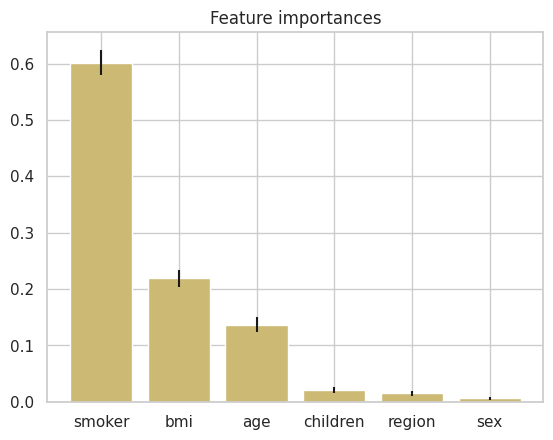

In [ ]:
print('Feature importance ranking\n\n')
importances = Rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in Rfr.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
variables = ['age', 'sex', 'bmi', 'children','smoker', 'region']
importance_list = []
for f in range(x.shape[1]):
    variable = variables[indices[f]]
    importance_list.append(variable)
    print("%d.%s(%f)" % (f + 1, variable, importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(importance_list, importances[indices],
       color="y", yerr=std[indices], align="center")

<font size=5><p style="color:purple"> Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
x = df.drop(['charges', 'sex', 'region'], axis = 1)
y = df.charges
pol = PolynomialFeatures (degree = 2)
x_pol = pol.fit_transform(x)
x_train, x_test, y_train, y_test = holdout(x_pol, y, test_size=0.2, random_state=0)
Pol_reg = LinearRegression()
Pol_reg.fit(x_train, y_train)
y_train_pred = Pol_reg.predict(x_train)
y_test_pred = Pol_reg.predict(x_test)
print(Pol_reg.intercept_)
print(Pol_reg.coef_)
print(Pol_reg.score(x_test, y_test))

-5325.8817052531285
[ 0.00000000e+00 -4.01606591e+01  5.23702019e+02  8.52025026e+02
 -9.52698471e+03  3.04430186e+00  1.84508369e+00  6.01720286e+00
  4.20849790e+00 -9.38983382e+00  3.81612289e+00  1.40840670e+03
 -1.45982790e+02 -4.46151855e+02 -9.52698471e+03]
0.8812595703345227


<font size='2' font >Awesome! :)

In [ ]:
##Evaluating the performance of the algorithm
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

Mean Absolute Error: 2824.495045477652
Mean Squared Error: 18895160.098780397
Root Mean Squared Error: 4346.856346692446


In [ ]:
##Predicting the charges
y_test_pred = Pol_reg.predict(x_test)
##Comparing the actual output values with the predicted values
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
df

,Actual,Predicted
578,9724.53000,12101.156323
610,8547.69130,10440.782266
569,45702.02235,48541.022951
1034,12950.07120,14140.067522
198,9644.25250,8636.235727
...,...,...
1084,15019.76005,16712.196281
726,6664.68595,8654.565461
1132,20709.02034,12372.050609
725,40932.42950,41465.617268


from matplotlib import pyplot as plt
df['Actual'].plot(kind='hist', bins=20, title='Actual')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Predicted'].plot(kind='hist', bins=20, title='Predicted')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Actual', y='Predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Actual'].plot(kind='line', figsize=(8, 4), title='Actual')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Predicted'].plot(kind='line', figsize=(8, 4), title='Predicted')
plt.gca().spines[['top', 'right']].set_visible(False)

<font size=2> **Conclusion:** like we previously noticed **smoking** is the greatest factor that affects medical cost charges, then it's **bmi** and **age**. **Polynomial Regression** turned out to be the best model